In [1]:
import matplotlib.pyplot as plt
from metamod.utils import maml_routine
import torch
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
from tqdm import tqdm
import pickle
import os
import glob
import pandas as pd
import matplotlib.cm as cm

In [2]:
from metamod.tasks import MultiTask, MNIST

In [3]:
results_path = "../../results/maml_sweep/"

In [4]:
def extract_mean_var(f, results_path, **kwargs):
    skip_steps = 20
    n_runs = 10
    n_steps = np.arange(0, 301, skip_steps)
    n_steps[0] = 2
    mean_quantity = []
    std_quantity = []
    for step in n_steps:
        step_quantity = []
        for run in range(n_runs):
            path = os.path.join(results_path, "MAML_sweep_run_"+str(run)+"_n_steps_"+str(step)+"_*")
            file_path = glob.glob(path)[0]
            results = pd.read_pickle(os.path.join(file_path, "results.pkl"))
            step_quantity.append(f(results, **kwargs))
        step_quantity = np.stack(step_quantity, axis=0)
        mean_quantity.append(np.mean(step_quantity, axis=0))
        std_quantity.append(np.std(step_quantity, axis=0))
    return np.array(mean_quantity), np.array(std_quantity), n_steps

In [5]:
results = pd.read_pickle("/home/rodrigo/SSD/Projects/neuromod/results/maml_sweep/MAML_sweep_run_0_n_steps_2_07-05-2023_18-40-05-492/results.pkl")

In [6]:
type(results["cumulated_reward_opt"])

numpy.ndarray

In [7]:
results.keys()

dict_keys(['iters', 'Loss_t_sim', 'weights_sim', 'weights_iters_sim', 'Loss_t_sim_test', 'avg_Loss_t_sim', 'avg_Loss_t_sim_test', 'time_span', 'eval_time_span', 'W1_t_eq', 'W2_t_eq', 'Loss_t_eq', 'Loss_t_eq_test', 'W1_t_control_init', 'W2_t_control_init', 'Loss_t_control_init', 'Loss_t_control_init_test', 'control_signal_init', 'cumulated_reward_opt', 'W1_grad', 'W2_grad', 'W1_t_control_opt', 'W2_t_control_opt', 'Loss_t_control_opt', 'Loss_t_control_opt_test'])

In [8]:
def integrate_loss(results, training=True):
    if training:
        loss, time_span = results["Loss_t_control_opt"], results["eval_time_span"]
    else:
        loss, time_span = results["Loss_t_control_opt_test"], results["eval_time_span"]
    dt = time_span[1] - time_span[0]
    return np.sum(loss)*dt

In [9]:
mean_eval_loss, std_eval_loss, steps = extract_mean_var(f=integrate_loss, 
                                                        results_path=results_path,
                                                        training=True)

mean_eval_loss_test, std_eval_loss_test, steps = extract_mean_var(f=integrate_loss, 
                                                                  results_path=results_path,
                                                                  training=False)

In [10]:
std_eval_loss.shape

(16,)

In [11]:
fontsize = 14

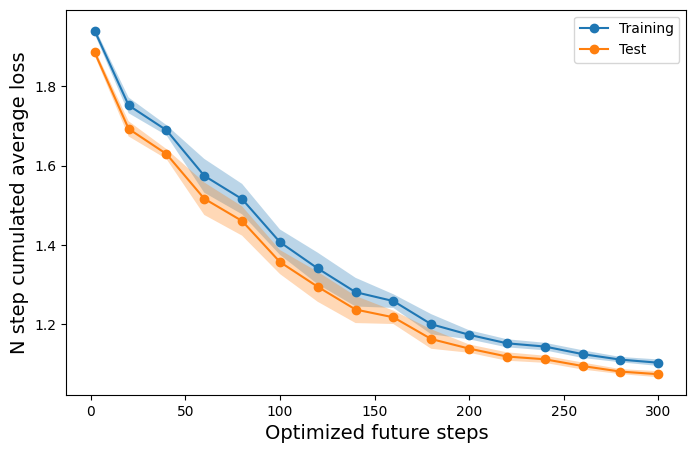

In [12]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(steps, mean_eval_loss, "C0-o", label="Training")
ax.fill_between(steps, y1=mean_eval_loss + std_eval_loss, y2=mean_eval_loss - std_eval_loss, alpha = 0.3)
ax.plot(steps, mean_eval_loss_test, "C1-o", label="Test")
ax.fill_between(steps, y1=mean_eval_loss_test + std_eval_loss_test, y2=mean_eval_loss_test - std_eval_loss_test, alpha = 0.3)
ax.legend()
ax.set_xlabel("Optimized future steps", fontsize=fontsize)
ax.set_ylabel("N step cumulated average loss", fontsize=fontsize)
plt.show()

In [13]:
def cumulated_reward(results):
    R = results["cumulated_reward_opt"]
    R = R/np.amax(R)
    return R

In [14]:
mean_cum_reward, std_cum_reward, steps = extract_mean_var(f=cumulated_reward, 
                                                          results_path=results_path)

In [15]:
mean_cum_reward.shape

(16, 500)

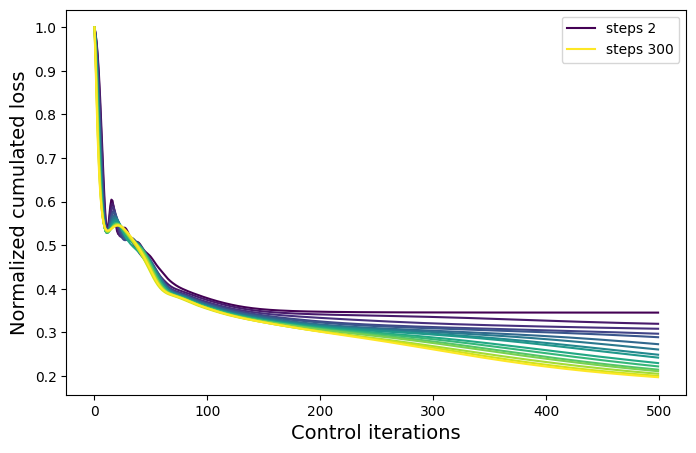

In [16]:
colors = cm.viridis(np.linspace(0, 1, mean_cum_reward.shape[0]))
f, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, step in enumerate(steps):
    if i == 0 or i == mean_cum_reward.shape[0] - 1:
        ax.plot(np.arange(mean_cum_reward.shape[1]), mean_cum_reward[i, :], color=colors[i], label="steps "+str(step))
    else:
        ax.plot(np.arange(mean_cum_reward.shape[1]), mean_cum_reward[i, :], color=colors[i])
ax.legend()
ax.set_xlabel("Control iterations", fontsize=fontsize)
ax.set_ylabel("Normalized cumulated loss", fontsize=fontsize)
plt.show()

## Why test set loss is lower?

In [17]:
dataset_params1 = {"batch_size": 256,
                       "new_shape": (5, 5),
                       "subset": (0, 1)}
dataset_params2 = {"batch_size": 256,
                   "new_shape": (5, 5),
                   "subset": (7, 1)}
dataset_params3 = {"batch_size": 256,
                   "new_shape": (5, 5),
                   "subset": (8, 9)}
dataset_params4 = {"batch_size": 256,
                   "new_shape": (5, 5),
                   "subset": (3, 8)}
dataset_params5 = {"batch_size": 256,
                   "new_shape": (5, 5),
                   "subset": (5, 3)}
dataset_params = {"dataset_classes": (MNIST, MNIST, MNIST, MNIST, MNIST),
                  "dataset_list_params": (dataset_params1, dataset_params2, dataset_params3,
                                          dataset_params4, dataset_params5)}

dataset_class = MultiTask
optimize_test = False
dataset = dataset_class(**dataset_params)

In [24]:
input_corr, output_corr, input_output_corr, expected_y, expected_x = dataset.get_correlation_matrix(training=False)
best_training_loss = dataset.get_best_possible_error(training=True)
training_linear_mapping = dataset.get_linear_regression_solution()
best_test_loss = []
for i, linear_map in enumerate(training_linear_mapping):
    min_test_loss = (np.trace(output_corr[i]) - np.trace(linear_map @ input_output_corr[i]))/2.0
    best_test_loss.append(min_test_loss)

print(best_training_loss, best_test_loss)

[0.020885764312144173, 0.03583208179540309, 0.05469398969183481, 0.08850465209129121, 0.0879402579424432] [0.016796712098300248, 0.03518309091871091, 0.05139215394175278, 0.08096274852137597, 0.08060201846931087]


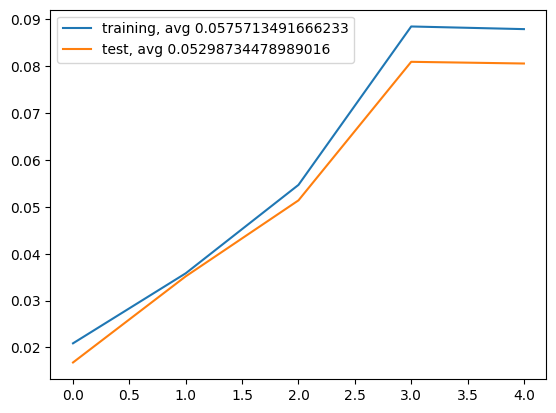

In [25]:
plt.plot(best_training_loss, label="training, avg " + str(np.mean(best_training_loss)))
plt.plot(best_test_loss, label="test, avg "+str(np.mean(best_test_loss)))
plt.legend()
plt.show()